In [7]:
# helpers
from migen.fhdl.verilog import convert
import tempfile
from IPython.display import SVG, display

def verilog2blocsvg(vlog):
    with open('m.v', 'w') as f:
        f.write(str(vlog)) 
    hideoutput = !symbolator -i m.v
    return SVG('m-top.svg')


def module2blocsvg(module, ios):
    return verilog2svg(convert(m, ios=ios))

def str2tmpfile(s, suffix):
    with tempfile.NamedTemporaryFile(mode='w', buffering=-1, suffix=suffix, delete=False) as f:
        name = f.name
        f.write(str(s))
    return name

# What are FPGA?

Field Programmable Gate Array

Basically it's a whiteboard on which you can draw (nearly) any kind of logic.
Contrary to SoC or CPUs you can buy on the market, where a single CPU runs (almost) sequentially each instruction,  everything can run in parallel in an FPGA.

# Hardware Description Language
FPGA don't "run code", you describe the logic that runs into it.
The toolchain then creates (one of) the configuration that fits this descrption.

# Workflow
Nowadays, most toolchains uses roughly the same steps (and terminology) for building a complete FPGA configuration from an HDL code :
1. Synthesis  
   1.1. RTL generation: convert HDL into a machine representation made with abstract blocks (logic, registers) and connection between them. That's *Register-Transfer level*. Some reduction logic optimization are usually aplied at this stage (like truth table reduction)  
   1.2. Technology mapping : FPGAs comprise different logic elements, or specialized elements like DSP and RAM. At this stage, the toolchain translates the RTL into configured elements, which assembled together behave like the RTL describes it.  
   1.3. Optimization : there are plenty ways to skin a cat. Same with FPGAs, multitudes of solutions are valid for the same HDL design. Thus, the toolchain tries numerous of them at various steps in order to speed up or cut down cell usage
2. Place & Route  
   2.1. Packing : "pre-place" small parts of the design, roughly on the logic-cell level
   2.2. Placing : attributes a physical location to each of the packed pieces. Since routing of signals between cells is limited, this has a big impact on routing quality  
   2.3. Routing : the tool has to find a solution that makes all connections successfully, but at the same time it must respect timing criterias (shorter connection is faster)  
   2.4. Analysis: checks that the design is valid, that the timing specs are respected  
   
Let's have a look how [symbiflow](https://symbiflow.readthedocs.io/en/latest/toolchain-desc/design-flow.html) does it.

In [47]:
Vcc=2.5
R=50E3
i=Vcc/R
print(i*1e6)
print(10/24/30/i)

50.0
277.77777777777777


# Before we continue, let's install the toolchain for ECP5 / ICE40
```
yay boost cmake openocd
git clone https://github.com/SymbiFlow/prjtrellis.git # ECP5 'layout' database + bitstream generation tool
git clone https://github.com/YosysHQ/nextpnr.git # synthetizer, router 
# ICE40 'layout' database + bitstream generation tool
git clone https://github.com/YosysHQ/yosys.git # synthetizer, router
cd prjtrellis/libtrellis
cmake -DCMAKE_INSTALL_PREFIX=/usr . && make
sudo make install

/* Machine-generated using Migen */
module top(
	input start_i,
	input [6:0] dividend_i,
	input [6:0] divisor_i,
	output ready_o,
	output [6:0] quotient_o,
	output [6:0] remainder_o,
	input start_i_1,
	input [6:0] dividend_i_1,
	input [6:0] divisor_i_1,
	output ready_o_1,
	output [6:0] quotient_o_1,
	output [6:0] remainder_o_1,
	input sys_clk,
	input sys_rst
);

reg [13:0] d1_qr = 14'd0;
reg [2:0] d1_counter = 3'd0;
reg [6:0] d1_divisor_r = 7'd0;
wire [7:0] d1_diff;
reg [13:0] d2_qr = 14'd0;
reg [2:0] d2_counter = 3'd0;
reg [6:0] d2_divisor_r = 7'd0;
wire [7:0] d2_diff;
reg ce = 1'd0;
reg reset = 1'd0;

// synthesis translate_off
reg dummy_s;
initial dummy_s <= 1'd0;
// synthesis translate_on

assign quotient_o = d1_qr[6:0];
assign remainder_o = d1_qr[13:7];
assign ready_o = (d1_counter == 1'd0);
assign d1_diff = (d1_qr[13:6] - d1_divisor_r);
assign quotient_o_1 = d2_qr[6:0];
assign remainder_o_1 = d2_qr[13:7];
assign ready_o_1 = (d2_counter == 1'd0);
assign d2_diff = (d2_qr[13:6] - d2

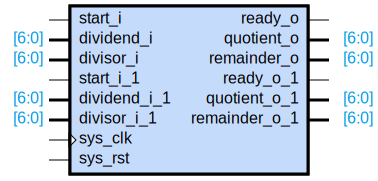

In [37]:
# We will create a trivial module to illustrate workflow steps
from migen import *
from migen.fhdl.verilog import convert
class mul(Module):
    def __init__(self, a, b, platform):
        self.platform = platform
        y = Signal(a.nbits + b.nbits)
        self.comb += y.eq(a*b) # counter increments each sys_clk rising edge
        self.ios = {a, b, y}

a = Signal(20)
b = Signal(6)
m = mul(a, b, None) # module instance
m = Example(7)
vlog = convert(m, ios=m.ios)
f_counter = str2tmpfile(vlog, '.v')
print(vlog)
display(verilog2blocsvg(vlog))

In [38]:
# Step 1.1 : RTL generation
# We follow techniques from http://www.clifford.at/yosys/files/yosys_appnote_011_design_investigation.pdf
ys = """
    read_verilog {}
    show
    """.format(f_counter)
a = !yosys {str2tmpfile(ys, '.ys')}
print('\n'.join(a))


 /----------------------------------------------------------------------------\
 |                                                                            |
 |  yosys -- Yosys Open SYnthesis Suite                                       |
 |                                                                            |
 |  Copyright (C) 2012 - 2019  Clifford Wolf <clifford@clifford.at>           |
 |                                                                            |
 |  Permission to use, copy, modify, and/or distribute this software for any  |
 |  purpose with or without fee is hereby granted, provided that the above    |
 |  copyright notice and this permission notice appear in all copies.         |
 |                                                                            |
 |  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES  |
 |  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF          |
 |  MERCHANTABILITY AND FITNESS. IN NO 

In [41]:
# Step 1.2 : technology mapping
ys = """
    read_verilog {}
    proc
    show
    """.format(f_counter)
a = !yosys {str2tmpfile(ys, '.ys')}
print('\n'.join(a))


 /----------------------------------------------------------------------------\
 |                                                                            |
 |  yosys -- Yosys Open SYnthesis Suite                                       |
 |                                                                            |
 |  Copyright (C) 2012 - 2019  Clifford Wolf <clifford@clifford.at>           |
 |                                                                            |
 |  Permission to use, copy, modify, and/or distribute this software for any  |
 |  purpose with or without fee is hereby granted, provided that the above    |
 |  copyright notice and this permission notice appear in all copies.         |
 |                                                                            |
 |  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES  |
 |  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF          |
 |  MERCHANTABILITY AND FITNESS. IN NO 

In [42]:
# Step 1.3 : Optimization
ys = """
    read_verilog {}
    proc
    opt
    show
    """.format(f_counter)
a = !yosys {str2tmpfile(ys, '.ys')}
print('\n'.join(a))


 /----------------------------------------------------------------------------\
 |                                                                            |
 |  yosys -- Yosys Open SYnthesis Suite                                       |
 |                                                                            |
 |  Copyright (C) 2012 - 2019  Clifford Wolf <clifford@clifford.at>           |
 |                                                                            |
 |  Permission to use, copy, modify, and/or distribute this software for any  |
 |  purpose with or without fee is hereby granted, provided that the above    |
 |  copyright notice and this permission notice appear in all copies.         |
 |                                                                            |
 |  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES  |
 |  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF          |
 |  MERCHANTABILITY AND FITNESS. IN NO 

In [ ]:
# Step 2 : pack, place, route
!nextpnr-ecp5 --gui --25k

# Migen
FHDL DSL in Python "A Python toolbox for building complex digital hardware"
* More restrictive than pure Verilog / VHDL (targeted mostly at FPGA)
* HDL itself isn't really better than any other options (except that it lets you do less mistakes)
* The true power comes from flexibility and modularity
* it's an HDL *generator*!

`python -m pip install --user git+https://github.com/m-labs/migen.git`

# Signals
A signal carries 1 or multiple 'bits' of information.
 * Fixed size, determined before synthetisation (you know what size it should be beforehand)
 * Fixed size, determined at synthetisation (the toolchain guesses from where the signal comes from)
 * Can be signed (optional)
 * represents either an input, output, the result of a combinatory circuit, or the value of a register
  * all of the above are automatically determined by Migen

In [11]:
from migen import Signal
a = Signal() # 1 bit signal
b = Signal(2) # 2 bits signal
c = Signal(max=32) # 5 bits signal (NOT 6!)
print("c", c.nbits)
d = Signal(reset=3) # 2 bits signal, reset (default) value set to 3
print("d", d.nbits)
e = Signal(name="mybeautyfulsignal", max=6)
print("e", e.nbits)
e = Signal(name="mybeautyfulsignedsignal", min=-6, max=6) # sign takes 1 bit
print("e", e.nbits)
f = Signal.like(e)

c 5
d 1
e 3
e 4


## Slicing
Using python slice
* `[2]` : select only the 3rd lowest-significant bit
* `[0:-4]` : select 1sth lowest, to 4th highest bit
* etc


In [ ]:
s = Signal(32, reset=0xdeadbeef)
s.nbits
print((s[0:4]))

# More ressources
 * Manual : [https://m-labs.hk/migen/manual/](https://m-labs.hk/migen/manual/)
 * Examples [https://github.com/m-labs/migen/tree/master/examples/basic](https://github.com/m-labs/migen/tree/master/examples/basic)
 * 

# Verilog / Migen comparison
Let's create a 'BCD to ACSII' converter as an example

In [12]:
from migen import Module, Case
class bcd2ascii_ifs(Module):
    def __init__(self, bcd):
        self.char = Signal(8)
        self.comb += [
            self.char.eq(ord('x')), # set the default value to 'x'
            If(bcd == 0,
                self.char.eq(ord('0'))
            ),
            If(bcd==1,
                self.char.eq(ord('1'))
            ),
            If(bcd==2,
                self.char.eq(ord('1'))
            )
            # and so on ...
        ]

# Let's convert this to Verilog!
from migen.fhdl.verilog import convert
bcd = Signal(4)    # input signal
m = bcd2ascii_ifs(bcd) # module instance
print(convert(m, ios={m.char, bcd}))

/* Machine-generated using Migen */
module top(
	input [3:0] bcd,
	output reg [7:0] char
);


// synthesis translate_off
reg dummy_s;
initial dummy_s <= 1'd0;
// synthesis translate_on


// synthesis translate_off
reg dummy_d;
// synthesis translate_on
always @(*) begin
	char <= 8'd0;
	char <= 7'd120;
	if ((bcd == 1'd0)) begin
		char <= 6'd48;
	end
	if ((bcd == 1'd1)) begin
		char <= 6'd49;
	end
	if ((bcd == 2'd2)) begin
		char <= 6'd49;
	end
// synthesis translate_off
	dummy_d <= dummy_s;
// synthesis translate_on
end

endmodule




In [13]:
from migen import Module, Case
class bcd2ascii_case(Module):
    def __init__(self, bcd):
        self.char = Signal(8)
        self.comb += Case(bcd, {i: self.char.eq(ord(c)) for i,c in enumerate("0123456789abcdef")})
        # If(bcd == 0, self.char.eq(ord('0'))).Elseif().Elseif()...

# Let's convert this to Verilog!
from migen.fhdl.verilog import convert
bcd = Signal(4)      # input signal
m = bcd2ascii_case(bcd) # module instance
print(convert(m, ios={m.char, bcd}))

/* Machine-generated using Migen */
module top(
	input [3:0] bcd,
	output reg [7:0] char
);


// synthesis translate_off
reg dummy_s;
initial dummy_s <= 1'd0;
// synthesis translate_on


// synthesis translate_off
reg dummy_d;
// synthesis translate_on
always @(*) begin
	char <= 8'd0;
	case (bcd)
		1'd0: begin
			char <= 6'd48;
		end
		1'd1: begin
			char <= 6'd49;
		end
		2'd2: begin
			char <= 6'd50;
		end
		2'd3: begin
			char <= 6'd51;
		end
		3'd4: begin
			char <= 6'd52;
		end
		3'd5: begin
			char <= 6'd53;
		end
		3'd6: begin
			char <= 6'd54;
		end
		3'd7: begin
			char <= 6'd55;
		end
		4'd8: begin
			char <= 6'd56;
		end
		4'd9: begin
			char <= 6'd57;
		end
		4'd10: begin
			char <= 7'd97;
		end
		4'd11: begin
			char <= 7'd98;
		end
		4'd12: begin
			char <= 7'd99;
		end
		4'd13: begin
			char <= 7'd100;
		end
		4'd14: begin
			char <= 7'd101;
		end
		4'd15: begin
			char <= 7'd102;
		end
	endcase
// synthesis translate_off
	dummy_d <= dummy_s;
// synthesis translate_on
en

In [ ]:
# We can also use an array defined locally if we don't want the trouble of creating a module
bcd_ascii = Array(C(ord(c)) for c in "0123456789abcdef")

# Let's convert this to Verilog!
class top_bcd2ascii_array(Module):
    def __init__(self, bcd):
        self.char = bcd_ascii[bcd]
    
from migen.fhdl.verilog import convert
bcd = Signal(4)      # input signal
m = bcd2ascii_case(bcd) # module instance
vlog = convert(m, ios={m.char, bcd})
display(verilog2svg(vlog))
print(vlog)

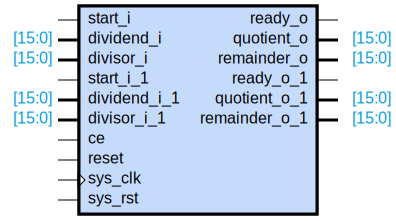

/* Machine-generated using Migen */
module top(
	input start_i,
	input [15:0] dividend_i,
	input [15:0] divisor_i,
	output ready_o,
	output [15:0] quotient_o,
	output [15:0] remainder_o,
	input start_i_1,
	input [15:0] dividend_i_1,
	input [15:0] divisor_i_1,
	output ready_o_1,
	output [15:0] quotient_o_1,
	output [15:0] remainder_o_1,
	input ce,
	input reset,
	input sys_clk,
	input sys_rst
);

reg [31:0] d1_qr = 32'd0;
reg [4:0] d1_counter = 5'd0;
reg [15:0] d1_divisor_r = 16'd0;
wire [16:0] d1_diff;
reg [31:0] d2_qr = 32'd0;
reg [4:0] d2_counter = 5'd0;
reg [15:0] d2_divisor_r = 16'd0;
wire [16:0] d2_diff;

// synthesis translate_off
reg dummy_s;
initial dummy_s <= 1'd0;
// synthesis translate_on

assign quotient_o = d1_qr[15:0];
assign remainder_o = d1_qr[31:16];
assign ready_o = (d1_counter == 1'd0);
assign d1_diff = (d1_qr[31:15] - d1_divisor_r);
assign quotient_o_1 = d2_qr[15:0];
assign remainder_o_1 = d2_qr[31:16];
assign ready_o_1 = (d2_counter == 1'd0);
assign d2_diff = (d2_qr

In [35]:
from migen import *
from migen.fhdl import verilog
from migen.genlib import divider


@ResetInserter()
@CEInserter()
class Example(Module):
    def __init__(self, width):
        d1 = divider.Divider(width)
        d2 = divider.Divider(width)
        self.submodules += d1, d2
        self.ios = {
            d1.ready_o, d1.quotient_o, d1.remainder_o, d1.start_i, d1.dividend_i, d1.divisor_i,
            d2.ready_o, d2.quotient_o, d2.remainder_o, d2.start_i, d2.dividend_i, d2.divisor_i}

if __name__ == "__main__":
    example = Example(16)
    vlog = verilog.convert(example, example.ios | {example.ce, example.reset})
    display(verilog2blocsvg(vlog))
    print(vlog)

# LiteX
'System on Chip' generator
* builds over Migen
* provides standard building blocks, and ways to put them together (CSR, memories, streams, bus arbiter, PCIe, SATA, SD, UART, ...) in a SoC
* generates a Verilog model of your SoC
* generates Software headers (.c/.h/.csv) for your peripherals
* calls the appropriate FPGA toolchain
* can build your Software aswell
* has tools to help you debug your SoC (like probing CSR, scoping signals)
* helps documenting your peripherals

`python -m pip install --user git+https://github.com/enjoy-digital/litex.git`

![litex_netv](https://raw.githubusercontent.com/enjoy-digital/netv2/master/doc/architecture.png)

# ULX3S
Simple board based on Lattice's ECP5
* [mainpage](https://ulx3s.github.io/)
![ulx3s](https://ulx3s.github.io/images/ulx3s-v303-ax-top_png_project-main.jpg)

# Litex ULX3S 'hello world'
<strike>Install litex-boards for ULX3S support-

`python -m pip install --user git+https://github.com/litex-hub/litex-boards.git`</strike> not required for ulx3s, but if yours is not natively supported in LiteX, have a look here

Install `ujprog` (original work https://github.com/f32c/tools but needs patches)
```
git clone https://github.com/chmousset/f32c-tools.git
cd f32c-tools/ujprog
mkdir build ; cd build
cmake ..
make && make install
```

In [14]:
# A bit of boilerplate...
from migen import * # the FHDL
from litex import * # the SoC builder
from litex.build.generic_platform import * # so we can use Pins(), etc to extend the platform
# the Platform represents the ulx3s 'capabilities', which FPGA brand/type is uses etc
from litex.boards.platforms.ulx3s import Platform

#import os
#os.makedirs('build')

def buildplat():
    # by default, LiteX uses Lattice's closed-source toolchain.
    # ULX3S has 4 FPGA size variants, set 'device' accordingly
    plat = Platform(toolchain="trellis", device="LFE5U-85F")

    # these IOs should probably be defined by default in litex, but since it's not we have to do it
    plat.add_extension([
        ("user_button", 0, Pins("D6"), IOStandard("LVCMOS33")),  # BTN_PWRn (inverted logic)
        ("user_button", 1, Pins("R1"), IOStandard("LVCMOS33")),  # FIRE1
        ("user_button", 2, Pins("T1"), IOStandard("LVCMOS33")),  # FIRE2
        ("user_button", 3, Pins("R18"), IOStandard("LVCMOS33")), # UP
        ("user_button", 4, Pins("V1"), IOStandard("LVCMOS33")),  # DOWN
        ("user_button", 5, Pins("U1"), IOStandard("LVCMOS33")),  # LEFT
        ("user_button", 6, Pins("H16"), IOStandard("LVCMOS33")), # RIGHT
    ])
    return plat

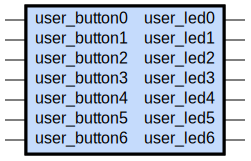

/* Machine-generated using Migen */
module top(
	output user_led0,
	input user_button0,
	output user_led1,
	input user_button1,
	output user_led2,
	input user_button2,
	output user_led3,
	input user_button3,
	output user_led4,
	input user_button4,
	output user_led5,
	input user_button5,
	output user_led6,
	input user_button6
);


// synthesis translate_off
reg dummy_s;
initial dummy_s <= 1'd0;
// synthesis translate_on

assign user_led0 = user_button0;
assign user_led1 = user_button1;
assign user_led2 = user_button2;
assign user_led3 = user_button3;
assign user_led4 = user_button4;
assign user_led5 = user_button5;
assign user_led6 = user_button6;

endmodule




In [15]:
# DEMO 1: LED display state of push buttons
class hello(Module):
    def __init__(self, plat):
        self.platform = plat
        self.ios = set()
        for i in range(7):
            led = plat.request("user_led", i)
            btn = plat.request("user_button", i)
            self.comb += led.eq(btn)
            self.ios = self.ios | {led, btn}

plat = buildplat()
top = hello(plat)
vlog = convert(top, ios=top.ios)
display(verilog2blocsvg(vlog))
print(vlog)

In [16]:
 
plat = buildplat()
b = plat.build(hello(plat), run=True)
prog = plat.create_programmer().load_bitstream('build/top.bit')

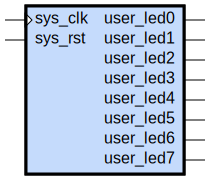

/* Machine-generated using Migen */
module top(
	output user_led0,
	output user_led1,
	output user_led2,
	output user_led3,
	output user_led4,
	output user_led5,
	output user_led6,
	output user_led7,
	input sys_clk,
	input sys_rst
);

reg [27:0] counter = 28'd0;

// synthesis translate_off
reg dummy_s;
initial dummy_s <= 1'd0;
// synthesis translate_on

assign user_led0 = counter[27];
assign user_led1 = counter[26];
assign user_led2 = counter[25];
assign user_led3 = counter[24];
assign user_led4 = counter[23];
assign user_led5 = counter[22];
assign user_led6 = counter[21];
assign user_led7 = counter[20];

always @(posedge sys_clk) begin
	counter <= (counter + 1'd1);
	if (sys_rst) begin
		counter <= 28'd0;
	end
end

endmodule




In [19]:
# DEMO 2: Binary counter. LED output MSB of the counter
class counter(Module):
    def __init__(self, plat):
        self.platform = plat
        counter = Signal(28) # we add 21 bits to slow down the LED frequencies
        self.sync += counter.eq(counter + 1) # counter increments each sys_clk rising edge
        self.ios = set()
        for i in range(8):
            led = plat.request("user_led", i)
            self.comb += led.eq(counter[-1-i]) # LED represent only the 8 MSb of the counter
            self.ios = self.ios | {led}
            # self.comb += plat.request("user_led", i).eq(counter[-1-i])

plat = buildplat()
top = counter(plat)
vlog = convert(top, top.ios)
display(verilog2blocsvg(vlog))
print(vlog)

In [20]:
plat = buildplat()
b = plat.build(counter(plat), run=True)
prog = plat.create_programmer().load_bitstream('build/top.bit')

# Demo references
* 

In [ ]:
import qrcode
qrcode.make("https://github.com/chmousset/fpga_workshop")